In [2]:
# LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics as met
from imblearn.pipeline import Pipeline


In [3]:
# DATASET

df = pd.read_excel("DryBeanDataset/Dry_Bean_Dataset.xlsx")
df = df.drop_duplicates(ignore_index=True)
df.rename(columns = {'AspectRation':'AspectRatio'}, inplace = True)
df = df.astype({'Area': 'float64'})
df = df.astype({'Class': 'string'})
df.info()
df.describe() # df[df['Class']=='BOMBAY'].describe()
labels = ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
features = df.columns.to_list();
features.remove('Class');
#features = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRatio', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 
#            'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2','ShapeFactor3', 'ShapeFactor4'];



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13543 entries, 0 to 13542
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13543 non-null  float64
 1   Perimeter        13543 non-null  float64
 2   MajorAxisLength  13543 non-null  float64
 3   MinorAxisLength  13543 non-null  float64
 4   AspectRatio      13543 non-null  float64
 5   Eccentricity     13543 non-null  float64
 6   ConvexArea       13543 non-null  int64  
 7   EquivDiameter    13543 non-null  float64
 8   Extent           13543 non-null  float64
 9   Solidity         13543 non-null  float64
 10  roundness        13543 non-null  float64
 11  Compactness      13543 non-null  float64
 12  ShapeFactor1     13543 non-null  float64
 13  ShapeFactor2     13543 non-null  float64
 14  ShapeFactor3     13543 non-null  float64
 15  ShapeFactor4     13543 non-null  float64
 16  Class            13543 non-null  string 
dtypes: float64(1

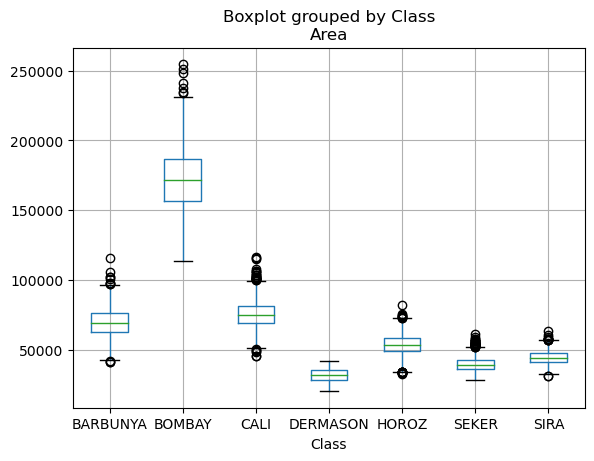

In [4]:
# BOXPLOTS

df.boxplot('Area', by='Class');

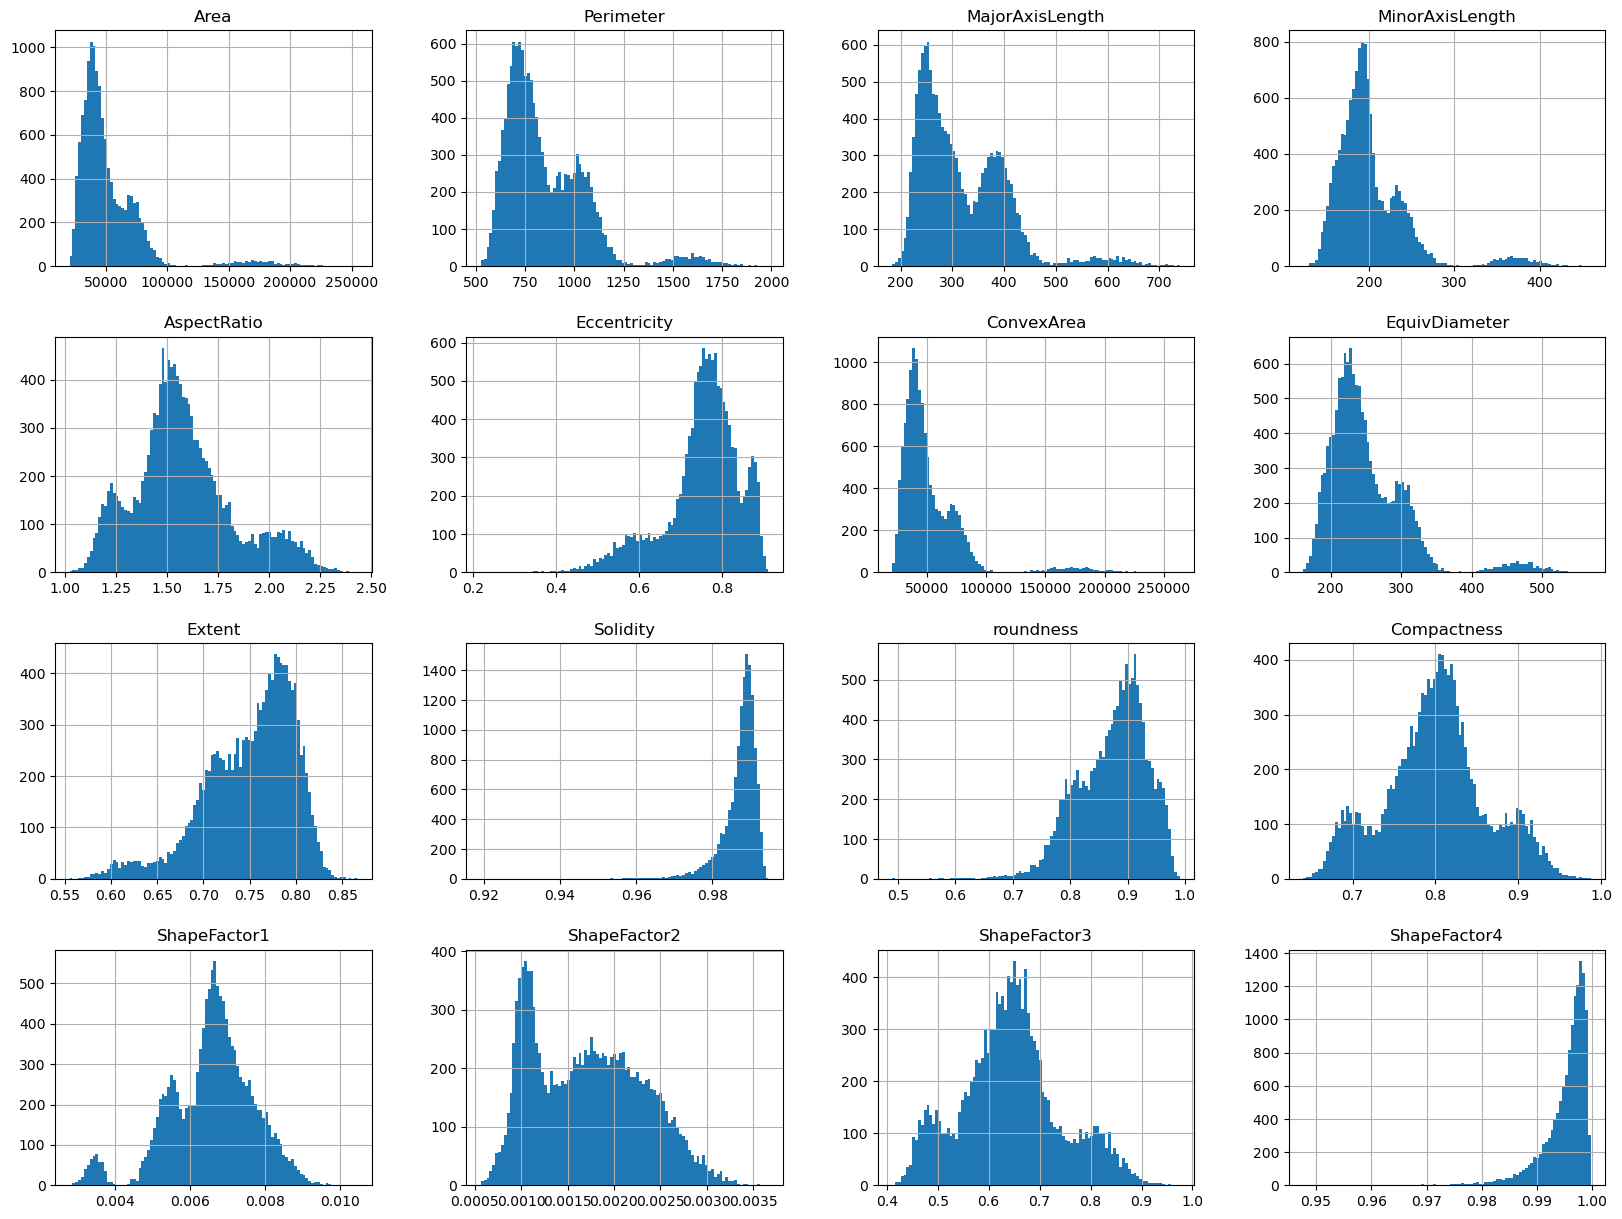

In [5]:
# HISTOGRAMS

df.hist(figsize=(20,15),bins=100); #Note: Through this plot we noticed the first correlations through shape
#df.groupby('Class').hist(figsize=(20,15),bins=100); #Note: It is not informative for our purposes

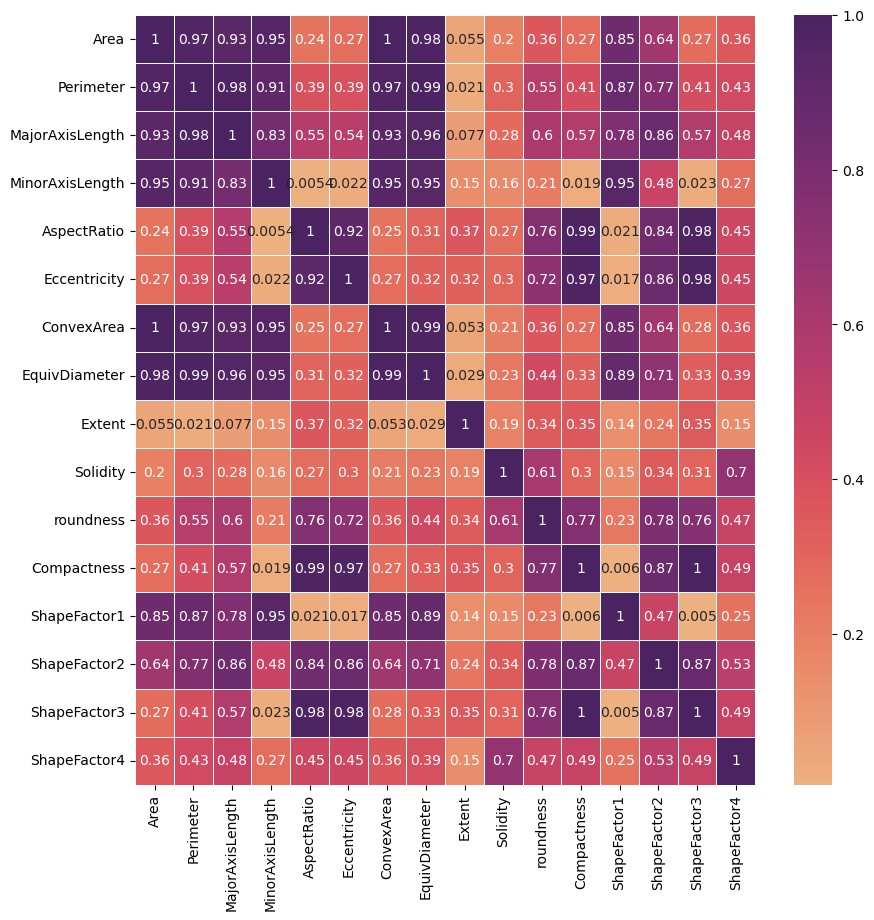

In [6]:
# CORRELATION

fig, ax = plt.subplots(figsize=(10,10)) 
CORR_MAP = df.corr(numeric_only = True).abs()
Steep = 10.0
Stretch = 2.002
if Stretch < 2.0 :
    Stretch = 2.0 
HIGH_CORR = (np.tan((np.pi/Stretch) * np.abs(CORR_MAP)) * (1 / Steep)) #LOW INFORMATION
LOW_CORR  = (np.tan((np.pi/Stretch) * (1 - np.abs(CORR_MAP))) * (1 / Steep)) #HIGH INFORMATION

sns.heatmap( CORR_MAP,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"
#sns.heatmap( HIGH_CORR,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"
#sns.heatmap( LOW_CORR,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"


In [7]:
# ARBITRARY DROPPING BY CORRELATION ANALYSIS
# Note: Area and ConvexArea are almost perfectly correlated: we already noticed that mathematically one is the square root of the other.
# Note: Compactness and Shape Factor 3 are almost perfectly correlated
# Proposition: Erase ConvexArea and Compactness

dfb = df.drop(['ConvexArea','Compactness'], axis=1);
#idx = 6453
#Ed = np.sqrt(4 * df.loc[idx].Area / np.pi);
#Co = Ed / df.loc[idx].MajorAxisLength;
#SF3 = df.loc[idx].Area / (np.pi * (df.loc[idx].MajorAxisLength / 2) * (df.loc[idx].MajorAxisLength / 2));

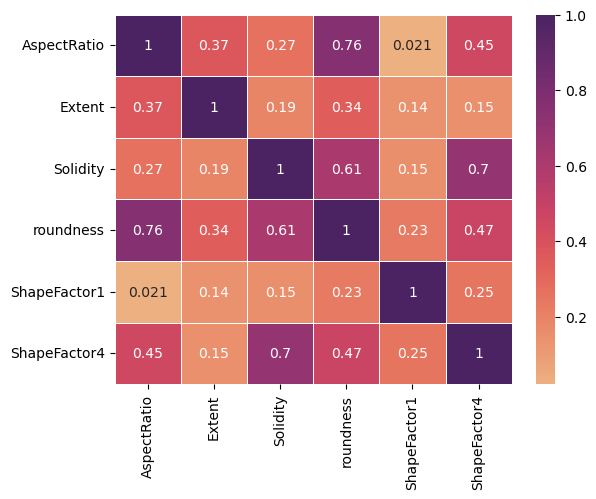

In [103]:
# PRUNING BY CORRELATION

dfc = df
corr = dfc.corr(numeric_only = True).abs()
drop = []
hold = []
p_threshold = 0.80

for i in range(0,corr.shape[0]):
    for j in range(i+1,corr.shape[1]):
        if corr.iloc[i,j]>=p_threshold:
            feature_i_corrsum = corr.iloc[i,:].sum()
            feature_j_corrsum = corr.iloc[j,:].sum()
            if feature_i_corrsum <= feature_j_corrsum:
                #hold.append(corr.index[i])
                #drop.append(corr.index[j])
                hold.append(i)
                drop.append(j)                
            else:
                #drop.append(corr.index[i])
                #hold.append(corr.index[j])
                drop.append(i)
                hold.append(j)

drop = list(set(drop))
drop = [list(corr.index)[i] for i in drop]
dfc = dfc.drop(drop, axis=1) 
corr = dfc.corr(numeric_only = True).abs()
sns.heatmap( corr,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r" """

In [9]:
# RANDOM FOREST FEATURE IMPORTANCE

dff = df
Xf = dff.iloc[:,:-1]
yf = dff.iloc[:,-1:]
X_train_f, X_test_f, y_train_f, y_test_f  = train_test_split(Xf, yf, test_size=0.3)

rnd_clf = RandomForestClassifier(
    n_estimators = 512, 
    criterion="gini",                      # {"gini", "entropy", "log_loss"}  
    min_samples_split = 2,
    max_features = "sqrt",                 # {"sqrt", "log2", None}
    bootstrap = True,
    oob_score = False,
    min_samples_leaf = 1, 
    max_depth = None
    )
rnd_clf.fit(X_train_f, y_train_f.values.ravel())

y_pred_rf = rnd_clf.predict(X_test_f)
print(met.classification_report(y_pred_rf, y_test_f));

feat_score = rnd_clf.feature_importances_

features_importances = pd.DataFrame(list(zip(features, feat_score)), columns =['features', 'score']);
features_importances = features_importances.sort_values(by=['score'], ascending=False);
features_importances = features_importances.reset_index(drop = True);
No_of_best = 11
if No_of_best < 1 or No_of_best > len(features_importances):
    No_of_best = len(features_importances)
best_features = features_importances.iloc[:No_of_best,0].tolist()
best_features.append('Class')

dfd = df.filter(best_features , axis=1);


              precision    recall  f1-score   support

    BARBUNYA       0.91      0.96      0.94       401
      BOMBAY       1.00      1.00      1.00       156
        CALI       0.94      0.92      0.93       478
    DERMASON       0.92      0.92      0.92      1058
       HOROZ       0.94      0.97      0.96       586
       SEKER       0.95      0.93      0.94       604
        SIRA       0.89      0.88      0.88       780

    accuracy                           0.93      4063
   macro avg       0.94      0.94      0.94      4063
weighted avg       0.93      0.93      0.93      4063



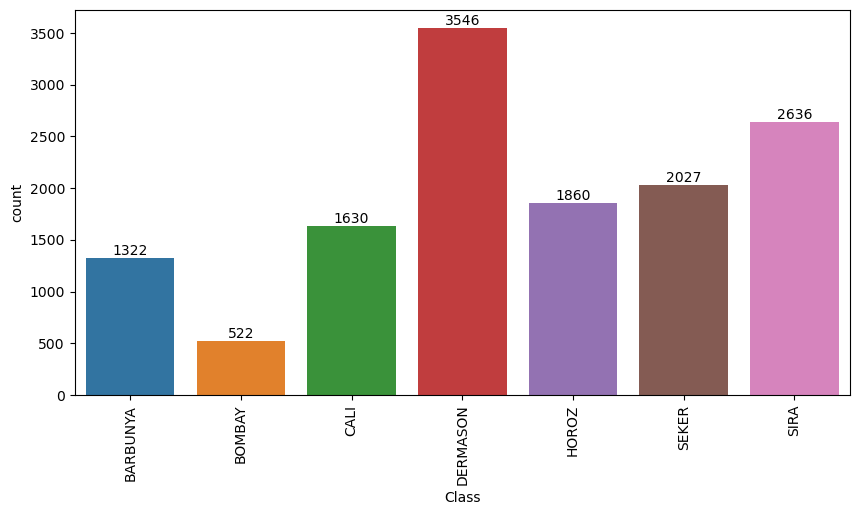

In [10]:
# CLASSES ANALYSIS

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

In [104]:
# TRAIN TEST SPLIT

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33)

df_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
# ANALYSIS
X_train_b = X_train.drop(['ConvexArea','Compactness'], axis=1);
X_test_b = X_test.drop(['ConvexArea','Compactness'], axis=1);
df_train_b = pd.merge(X_train_b, y_train, left_index=True, right_index=True);
# CORRELATION
X_train_c = X_train.drop(drop, axis=1);
X_test_c = X_test.drop(drop, axis=1);
df_train_c = pd.merge(X_train_c, y_train, left_index=True, right_index=True);
# FEATURE IMPORTANCE
X_train_d = X_train.filter(best_features , axis=1);
X_test_d = X_test.filter(best_features , axis=1);
df_train_d = pd.merge(X_train_d, y_train, left_index=True, right_index=True);


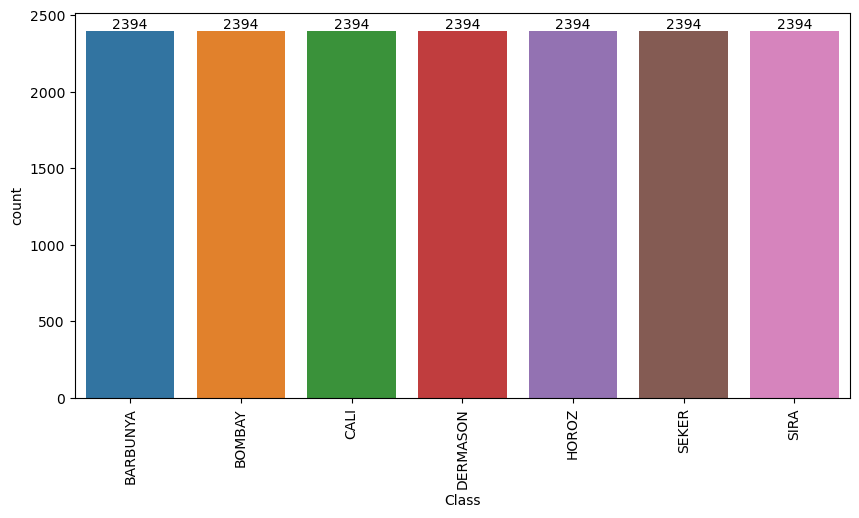

In [12]:
# OVERSAMPLING - SMOTE

smt = SMOTE()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
df_train_smt = pd.merge(X_train_smt, y_train_smt, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_smt, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

# ATTENZIONE, IL NUMERO DI ISTANZE PER CLASSE CAMBIA CONTINUAMENTE, DOPO LO SPLIT LA CLASSE CHE NE ESCE "VINCITRICE",
# LA MAGGIORMENTE SELEZIONA DETERMINA LA SOGLIA DI OVERSAMPLING


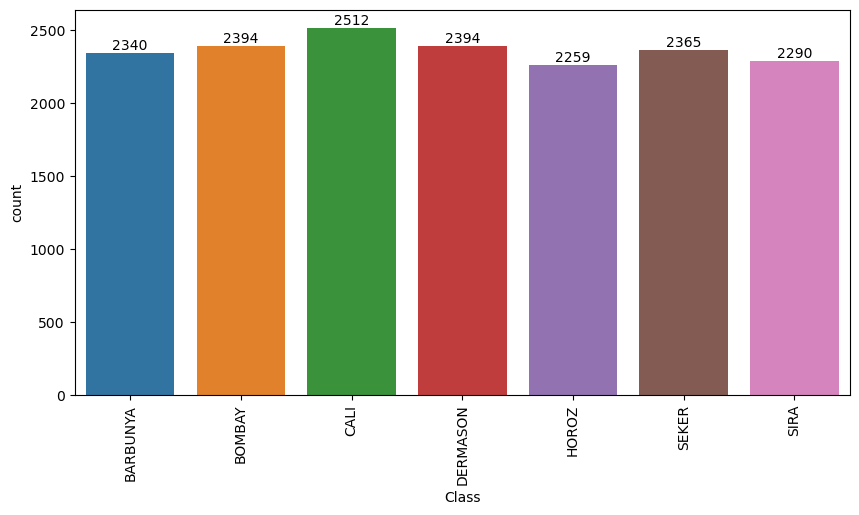

In [13]:
# OVERSAMPLING - ADASYN

ada = ADASYN()
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
df_train_ada = pd.merge(X_train_ada, y_train_ada, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_ada, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

# ATTENZIONE, IL NUMERO DI ISTANZE PER CLASSE CAMBIA CONTINUAMENTE, DOPO LO SPLIT LA CLASSE CHE NE ESCE "VINCITRICE",
# LA MAGGIORMENTE SELEZIONA DETERMINA LA SOGLIA DI OVERSAMPLING

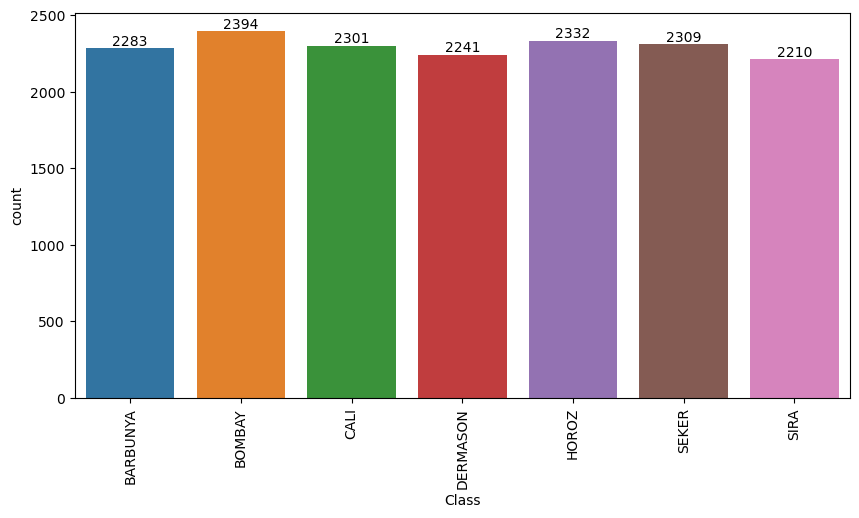

In [14]:
# HYBRIDIZATION - SMOTE+Tomek

stk = SMOTETomek()
X_train_stk, y_train_stk = stk.fit_resample(X_train, y_train)
df_train_stk = pd.merge(X_train_stk, y_train_stk, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_stk, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

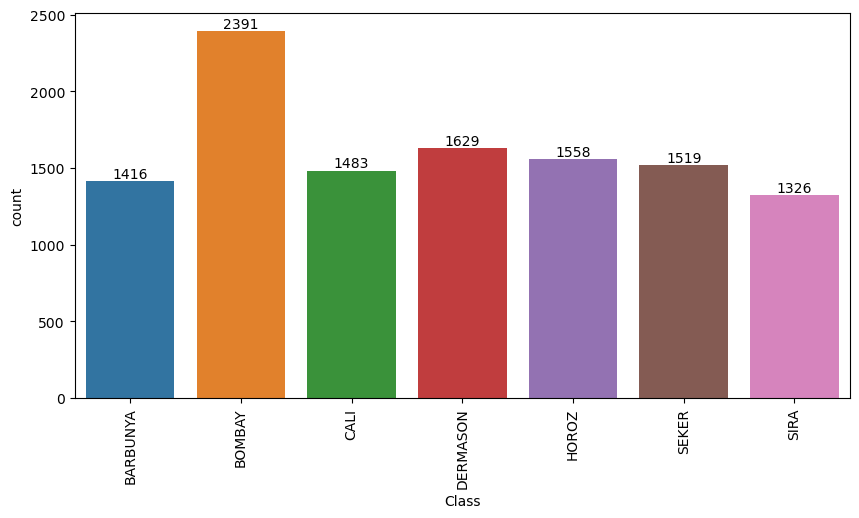

In [15]:
# HYBRIDIZATION - SMOTE+ENN

snn = SMOTEENN()
X_train_snn, y_train_snn = snn.fit_resample(X_train, y_train)
df_train_snn = pd.merge(X_train_snn, y_train_snn, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_snn, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

In [ ]:
# SCATTERPLOTS

#for item in dfs:
#    feats = item.columns.to_list();
#    pairs_features = [(a, b) for idx, a in enumerate(feats) for b in feats[idx + 1:]];
#    for pair in pairs_features:
#        plt.subplots(figsize=(10,5));
#        for label in labels:
#            sns.scatterplot(x=pair[0], y=pair[1], data=item[item['Class']==label]);
#            plt.legend(labels, fontsize = 10, loc=0);

In [63]:
# CLASS BALANCING + FEATURES SELECTION

dfz = [df_train, df_train_smt, df_train_ada, df_train_stk, df_train_snn]
class_balacing = 1 #[0 = No Balancing; 1 = SMOTE; 2 = ADASYN; 3 = SMOTE+TOMEK; 4 = SMOTE+ENN]
feature_selection = 2 # [0 = No Selection; 1 = Analysis; 2 = Correlation; 3 = Feature Importance]

if feature_selection == 0:
    Xz = dfz[class_balacing].iloc[:,:-1];
    yz = dfz[class_balacing].iloc[:,-1:];
    X_test_z = X_test;
if feature_selection == 1:
    Xz = dfz[class_balacing].iloc[:,:-1].drop(['ConvexArea','Compactness'], axis=1);
    yz = dfz[class_balacing].iloc[:,-1:];
    X_test_z = X_test_b;
if feature_selection == 2:
    Xz = dfz[class_balacing].iloc[:,:-1].drop(drop, axis=1);
    yz = dfz[class_balacing].iloc[:,-1:];
    X_test_z = X_test_c;
if feature_selection == 3:
    Xz = dfz[class_balacing].iloc[:,:-1].filter(best_features , axis=1);
    yz = dfz[class_balacing].iloc[:,-1:];
    X_test_z = X_test_d;



In [64]:
# ENSEMBLE METHODS

models = {
    "Random Forest": RandomForestClassifier(
        min_samples_leaf=1, max_depth = None, bootstrap = True, 
        oob_score = False, min_samples_split = 2,
    ),
     "Extra Trees": ExtraTreesClassifier(
        min_samples_leaf=1, max_depth = None, bootstrap = False, 
        oob_score = False, min_samples_split = 2,
    ),
}

param_grids = {
    "Random Forest": {
        "n_estimators": [32], 
        "criterion": ["gini"],                    # {"gini", "entropy", "log_loss"}
        "max_features": ["sqrt"],                 # {"sqrt", "log2", None}
                      },
    "Extra Trees":   {
        "n_estimators":  [32], 
        "criterion": ["gini"],                    # {"gini", "entropy", "log_loss"}
        "max_features": ["sqrt"],                 # {"sqrt", "log2", None}
                      } 
}

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring = 'accuracy',
        n_jobs = None,
        refit = True,        
        cv=KFold(n_splits=5, shuffle=True),        
        verbose = 4,
        return_train_score=True,
        ).fit(Xz, yz.values.ravel())
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

y_pred_test = grid_search.predict(X_test_z) #best_estimator_.
print(met.classification_report(y_pred_test, y_test));

cv_score = grid_search.best_score_
test_score = grid_search.score(X_test_z, y_test)

print(cv_score)
print(test_score)
#print(results)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_features=sqrt, n_estimators=32;, score=(train=1.000, test=0.948) total time=   1.0s
[CV 2/5] END criterion=gini, max_features=sqrt, n_estimators=32;, score=(train=1.000, test=0.951) total time=   0.9s
[CV 3/5] END criterion=gini, max_features=sqrt, n_estimators=32;, score=(train=1.000, test=0.959) total time=   0.8s
[CV 4/5] END criterion=gini, max_features=sqrt, n_estimators=32;, score=(train=1.000, test=0.956) total time=   0.8s
[CV 5/5] END criterion=gini, max_features=sqrt, n_estimators=32;, score=(train=1.000, test=0.953) total time=   0.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_features=sqrt, n_estimators=32;, score=(train=1.000, test=0.962) total time=   0.1s
[CV 2/5] END criterion=gini, max_features=sqrt, n_estimators=32;, score=(train=1.000, test=0.955) total time=   0.3s
[CV 3/5] END criterion=gini, max_features=sqrt, n_estimators=32

In [113]:
# FEATURES SELECTION MODE

feature_selection = 2 # [0 = No Selection; 1 = Analysis; 2 = Correlation; 3 = Feature Importance]

if feature_selection == 0:
    Xz = df_train.iloc[:,:-1];
    yz = df_train.iloc[:,-1:];
    X_test_z = X_test;
if feature_selection == 1:
    Xz = df_train.iloc[:,:-1].drop(['ConvexArea','Compactness'], axis=1);
    yz = df_train.iloc[:,-1:];
    X_test_z = X_test_b;
if feature_selection == 2:
    Xz = df_train.iloc[:,:-1].drop(drop, axis=1);
    yz = df_train.iloc[:,-1:];
    X_test_z = X_test_c;
if feature_selection == 3:
    Xz = df_train.iloc[:,:-1].filter(best_features , axis=1);
    yz = df_train.iloc[:,-1:];
    X_test_z = X_test_d;

# ENSEMBLE METHODS

PIPE = Pipeline([[ 'over', SMOTE() ] , [ 'classifier',RandomForestClassifier() ]]) #[ None, SMOTE(), ADASYN(), SMOTETomek(), SMOTEENN()]

models = {
    "Random Forest": RandomForestClassifier(
        min_samples_leaf=1, max_depth = None, bootstrap = True, 
        oob_score = False, min_samples_split = 2,
    ),
     "Extra Trees": ExtraTreesClassifier(
        min_samples_leaf=1, max_depth = None, bootstrap = False, 
        oob_score = False, min_samples_split = 2,
    ),
}

param_grids = {
    "Random Forest": {
        "classifier__n_estimators": [256], 
        "classifier__criterion": ["gini"],                    # {"gini", "entropy", "log_loss"}
        "classifier__max_features": ["sqrt"],                 # {"sqrt", "log2", None}
                      },
    "Extra Trees":   {
        "classifier__n_estimators":  [256], 
        "classifier__criterion": ["gini"],                    # {"gini", "entropy", "log_loss"}
        "classifier__max_features": ["sqrt"],                 # {"sqrt", "log2", None}
                      } 
}

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=PIPE,
        param_grid=param_grids[name],
        scoring = 'accuracy',
        n_jobs = None,
        refit = True,        
        cv=KFold(n_splits=5, shuffle=True),        
        verbose = 4,
        return_train_score=True,
        ).fit(Xz, yz.values.ravel())
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

y_pred_test = grid_search.predict(X_test_z) #best_estimator_.
print(met.classification_report(y_pred_test, y_test));

cv_score = grid_search.best_score_
test_score = grid_search.score(X_test_z, y_test)

print(cv_score)
print(test_score)
print(results)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__criterion=gini, classifier__max_features=sqrt, classifier__n_estimators=256;, score=(train=1.000, test=0.923) total time=   8.4s
[CV 2/5] END classifier__criterion=gini, classifier__max_features=sqrt, classifier__n_estimators=256;, score=(train=1.000, test=0.935) total time=   8.2s
[CV 3/5] END classifier__criterion=gini, classifier__max_features=sqrt, classifier__n_estimators=256;, score=(train=1.000, test=0.923) total time=   7.9s
[CV 4/5] END classifier__criterion=gini, classifier__max_features=sqrt, classifier__n_estimators=256;, score=(train=1.000, test=0.929) total time=   8.1s
[CV 5/5] END classifier__criterion=gini, classifier__max_features=sqrt, classifier__n_estimators=256;, score=(train=1.000, test=0.929) total time=   8.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__criterion=gini, classifier__max_features=sqrt, classifier__n_estimators=256;, score=(tr

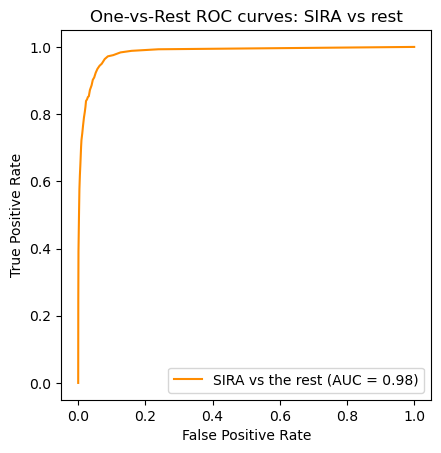

In [76]:
#SCORING

# CLASSES: ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']

y_score = grid_search.predict_proba(X_test_z)
label_binarizer = LabelBinarizer().fit(yz)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform(["SIRA"])

class_of_interest = "SIRA"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

met.RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: " + class_of_interest + " vs rest")
plt.legend()
plt.show()

# FPR = 1 when threshold = 0% or TN = 0
# TPR = 0 when threshold = 1000% or TP = 0